In [2]:
import zipfile

with zipfile.ZipFile('Copy of devnagari digit.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

# **Task 1: Data Preparation**

Training set: (17000, 28, 28, 1), Labels: (17000, 10)
Testing set: (3000, 28, 28, 1), Labels: (3000, 10)


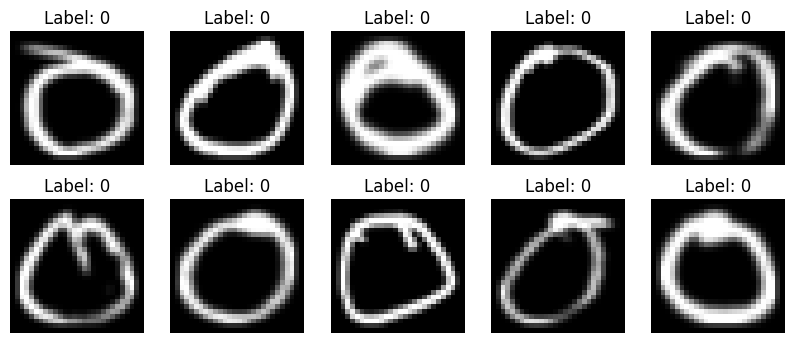

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow
# Define dataset paths
train_dir = "/content/extracted_data/DevanagariHandwrittenDigitDataset/Train"
test_dir = "/content/extracted_data/DevanagariHandwrittenDigitDataset/Test"
# Define image size
img_height, img_width = 28, 28
# Function to load images and labels using PIL
# Function to load images and labels using PIL
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder)) # Sorted class names (digit_0, digit_1, ...)
    class_map = {name: i for i, name in enumerate(class_names)} # Map class names to labels
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            # Load image using PIL
            img = Image.open(img_path).convert("L") # Convert to grayscale
            img = img.resize((img_width, img_height)) # Resize to (28,28)
            img = np.array(img) / 255.0 # Normalize pixel values to [0,1]
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)
# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)
# Reshape images for Keras input
x_train = x_train.reshape(-1, img_height, img_width, 1) # Shape (num_samples, 28, 28, 1)
x_test = x_test.reshape(-1, img_height, img_width, 1)
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")
# Visualize some images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray') # Corrected cmap to 'gray'
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")
plt.show()

### **Task 2: Build the FCN Model**

In [4]:
# Model parameters
import tensorflow as tf
from tensorflow import keras
num_classes = 10
input_shape = (28, 28, 1)
model = keras.Sequential(
  [
    keras.layers.Input(shape=input_shape),
    keras.layers.Flatten(), # Flatten the 28x28 image to a 784-dimensional vector
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(128, activation="sigmoid"),
    keras.layers.Dense(256, activation="sigmoid"),
    keras.layers.Dense(num_classes, activation="softmax"),
  ]
)

### Model Summary

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

## Task 3: Compile the Model

In [6]:
model.compile(
optimizer="adam", # Stochastic Gradient Descent
loss="categorical_crossentropy", # Loss function for multi-class classification
metrics=["accuracy"] # Track accuracy during training
)

### **Task 4: Train the Model**

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# EarlyStopping to stop training if validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model with callbacks
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=20,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1816 - loss: 2.1089
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1859 - loss: 2.1037 - val_accuracy: 0.0000e+00 - val_loss: 7.0755
Epoch 2/20
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6459 - loss: 1.3490
Epoch 2: val_accuracy did not improve from 0.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6534 - loss: 1.3229 - val_accuracy: 0.0000e+00 - val_loss: 7.8049
Epoch 3/20
50/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8447 - loss: 0.5988
Epoch 3: val_accuracy did not improve from 0.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8464 - loss: 0.5913 - val_accuracy: 0.0000e+00 - val_loss: 8.7079
Epoch 4/20
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9107 - loss: 0.3425
Epoch 4: val_accuracy did not improve from 0.00000
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9113 - loss: 0.3397 - val_accuracy: 0.0000e+00 - val_loss: 9.3268
Epoch 5/20
49/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9341 - loss: 0.2448
Epoch 5: val_accuracy did not imp

## **Task 5: Evaluate the Model**

In [8]:

loss, accuracy = model.evaluate(
       x=x_test,
       y=y_test,
       batch_size=64,
       verbose=2
   )

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


47/47 - 0s - 3ms/step - accuracy: 0.7583 - loss: 2.1362
Test Loss: 2.1362
Test Accuracy: 0.7583


# **Task 6: Save and Load the Model**

In [9]:
# Save the trained model
model.save("my_trained_model.h5")

## **Load The Model**

In [10]:
from tensorflow import keras

# Load the saved model
loaded_model = keras.models.load_model("my_trained_model.h5")

# Re-evaluate the model
loss, accuracy = loaded_model.evaluate(x_test, y_test, verbose=1)

print(f"Loaded Model - Test Loss: {loss:.4f}")
print(f"Loaded Model - Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9346 - loss: 0.4030
Loaded Model - Test Loss: 2.1362
Loaded Model - Test Accuracy: 0.7583


## **Task 7: Predictions**

In [11]:
# Making Predictions
predictions = model.predict(x_test)

# Convert predictions from probabilities to digit labels
predicted_labels = np.argmax(predictions, axis=1)

for i in range(10):
    print(f"Image {i + 1}:")
    print(f"  Predicted label: {predicted_labels[i]}")
    print(f"  True label: {np.argmax(y_test[i])}")
    print()


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Image 1:
  Predicted label: 0
  True label: 0

Image 2:
  Predicted label: 0
  True label: 0

Image 3:
  Predicted label: 0
  True label: 0

Image 4:
  Predicted label: 0
  True label: 0

Image 5:
  Predicted label: 0
  True label: 0

Image 6:
  Predicted label: 0
  True label: 0

Image 7:
  Predicted label: 0
  True label: 0

Image 8:
  Predicted label: 0
  True label: 0

Image 9:
  Predicted label: 0
  True label: 0

Image 10:
  Predicted label: 0
  True label: 0



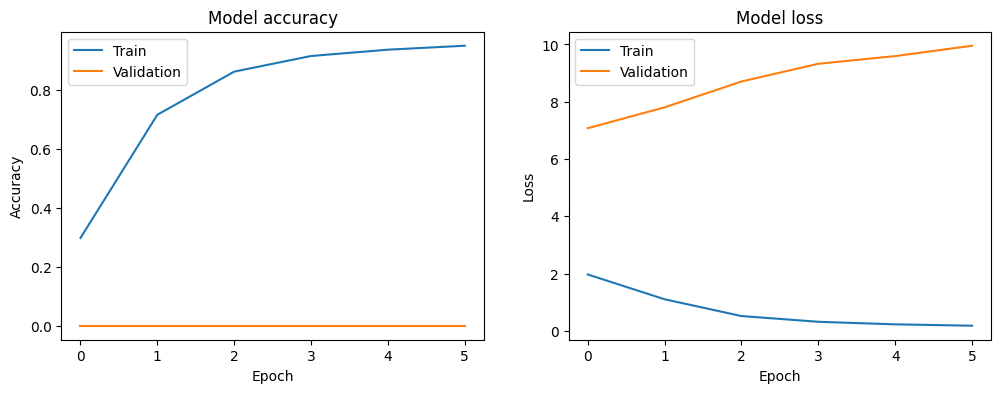

In [12]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the training history in the 'history' variable

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()